In [20]:
# -- IMPORTS START --
import pandas as pd
import glob
import re
import os
import sys
import pickle
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn import tree, metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from scipy.signal import butter, filtfilt, find_peaks
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.model_selection import train_test_split
# -- IMPORTS END --

# enable zooming into graphs
%matplotlib notebook
plt.rcParams['figure.figsize'] = [9, 6] # width, height in inches

In [21]:
# Helper function to visualize model - Do not modify
def viz_tree(dt_model,features_frames,cnames):
    # Fix feature names as list
    feature_names = features_frames.columns.tolist()

    fig, ax = plt.subplots(figsize=(9,4))
    tree.plot_tree(dt_model,  
                   feature_names=feature_names,
                   fontsize=7,
                   class_names=cnames,
                   filled=True,
                   ax=ax)

    plt.title('Decision Tree')
    plt.savefig('dt.png')

In [22]:
def calc_magnitude(data):

    # Calculate magnitude  
    data['accel_mag'] = np.sqrt(data['x']**2 + data['y']**2 + data['z']**2) # absolute accel magnitude
    data['gyro_mag'] = np.sqrt(data['gyro_x']**2 + data['gyro_y']**2 + data['gyro_z']**2) # absolute gyro magnitude
    data['accel_mag'] = data['accel_mag'] - data['accel_mag'].mean() # detrend: "remove gravity"

    return data

In [23]:
def remove_noise(data,sampling_rate):
    from scipy.signal import butter, filtfilt, find_peaks

    # Low pass filter
    cutoff = 5 # Hz
    order = 2
    b, a = butter(order, cutoff/(sampling_rate/2), btype='lowpass')
    data['filtered_accel_mag'] = filtfilt(b, a, data['accel_mag'])
    data['filtered_gyro_mag'] = filtfilt(b, a, data['gyro_mag'])
    data['filtered_x'] = filtfilt(b, a, data['gyro_x'])
    data['filtered_y'] = filtfilt(b, a, data['gyro_y'])
    data['filtered_z'] = filtfilt(b, a, data['gyro_z'])

    return data

In [24]:
#Do not modify
def add_features(window):
    features = {}
    features['avg'] = window['accel_mag'].mean()
    features['max'] = window['accel_mag'].quantile(1)
    features['med'] = window['accel_mag'].quantile(0.5)
    features['min'] = window['accel_mag'].quantile(0)
    features['q25'] = window['accel_mag'].quantile(0.25)
    features['q75'] = window['accel_mag'].quantile(0.75)
    features['std'] = window['accel_mag'].std()
    features['gyro_avg'] = window['gyro_mag'].mean()
    features['gyro_max'] = window['gyro_mag'].quantile(1)
    features['gyro_med'] = window['gyro_mag'].quantile(0.5)
    features['gyro_min'] = window['gyro_mag'].quantile(0)
    features['gyro_q25'] = window['gyro_mag'].quantile(0.25)
    features['gyro_q75'] = window['gyro_mag'].quantile(0.75)
    features['gyro_std'] = window['gyro_mag'].std()
    df = pd.DataFrame()
    df = df.append(features,ignore_index=True)
    return df

In [32]:
def train_decision_tree(frames):
    # Extract feature columns 
    #Use all features
    #X = frames[['avg', 'max', 'med', 'min', 'q25', 'q75', 'std','gyro_avg', 'gyro_max', 'gyro_med', 'gyro_min', 'gyro_q25', 'gyro_q75', 'gyro_std']]
    #Use only accelerometer features
    #X = frames[['avg', 'max', 'med', 'min', 'q25', 'q75', 'std']]
    #Use only gyroscope features
    X = frames[['gyro_avg', 'gyro_max', 'gyro_med', 'gyro_min', 'gyro_q25', 'gyro_q75', 'gyro_std']]
    # Extract target column
    y = frames['activity']

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 

    # Create model
    dt_model = DecisionTreeClassifier(criterion='entropy',max_depth=5).fit(X_train, y_train)
    feature_importances = dt_model.feature_importances_
    print(feature_importances)
    dt_pred = dt_model.predict(X_test)

    # Evaluate on test set
    acc = dt_model.score(X_test, y_test)
    dt_cm = confusion_matrix(y_test, dt_pred, labels=dt_model.classes_)
    print(classification_report(y_test, dt_pred))
    print("Accuracy on test set:", acc)

    return dt_model,dt_cm,acc

In [33]:
def classify_live_window(df):
    
    # Filter accelerometer data 
    df_accel = df[df['accel_x'].notna() & df['accel_y'].notna() & df['accel_z'].notna()]
    df_valid = df_accel[['accel_x', 'accel_y', 'accel_z']].rename(columns={
      'accel_x': 'x',
      'accel_y': 'y',
      'accel_z': 'z'  
    })

    # Calculate accel_mag
    df_valid = calc_magnitude(df_valid) 

    # Add features
    df_valid = add_features(df_valid) 
    X = df_valid[['avg', 'max', 'med', 'min', 'q25', 'q75',  'std']] 

    # Load model
    with open('dt_model.pkl', 'rb') as f:
        model = pickle.load(f)
        
    # Make prediction
    y_pred = model.predict(df_valid)

    return(y_pred)

In [34]:
def test_live_classification(): # Testing the live model
    # Generate sample DataFrame
    data = {'accel_x': [0.011531], 
            'accel_y': [0.002931],
            'accel_z': [0.019604],
            'time': ['2023-08-01 18:40:43.344408']}

    df = pd.DataFrame(data)

    # Repeat rows to get 1000 rows
    df = pd.concat([df]*1000, ignore_index=True) 

    # Call function
    y_pred = classify_live_window(df)

    print(y_pred)


In [35]:
# Function to extract windows and features 
def extract_features(data, window_sec, sample_rate, activity):
    # TODO - see instructions above
    finalDF = pd.DataFrame()
    for t, w in data.resample(str(window_sec)+'s'):
        window_features = add_features(w)
        window_features['activity'] = activity
        finalDF = finalDF.append(window_features, ignore_index=True)   
    return finalDF



In [36]:
#Helper function to combine the accelerometer and gyroscope files into one
def combine_and_save(accelerometer_file, gyroscope_file, output_file):
        # Read the CSV files into Pandas DataFrames
        accelerometer_data = pd.read_csv(accelerometer_file)
        gyroscope_data = pd.read_csv(gyroscope_file)
        # Add the 'x', 'y', and 'z' columns from the gyroscope to the accelerometer
        accelerometer_data['gyro_x'] = gyroscope_data['x']
        accelerometer_data['gyro_y'] = gyroscope_data['y']
        accelerometer_data['gyro_z'] = gyroscope_data['z']
        accelerometer_data['time'] = pd.to_datetime(accelerometer_data['time'], unit = 'ns')
        # Save the combined DataFrame to a new CSV file
        accelerometer_data.to_csv(output_file, index=False)

combine_and_save('Accelerometer.csv', 'Gyroscope.csv', 'rachel_combined_data.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'Accelerometer.csv'

In [37]:
def all_data_to_combined_csv():
    import os
    import sys
    
    # TODO - see instructions above
    # there is nothing to return from this function. 
    # The function is writing something to a file instead.
     # Initialize the combined DataFrame

    sample_rate = 100
    window_sec = 10

    all_data = pd.DataFrame()
    activities = ['standing', 'walk_good', 'walk_drunk', 'walk_slouch']
    
    for activity in activities:
        files = glob.glob(f'data/Activities/{activity}/*.csv')

        for file in files:
            df = pd.read_csv(file,parse_dates=['time'],index_col='time',)
            df = calc_magnitude(df)
            df = remove_noise(df, sample_rate)

            feature_frames = extract_features(df, window_sec, sample_rate, activity)
            all_data = all_data.append(feature_frames, ignore_index=True)

    all_data.to_csv('all_data.csv', index = False)
all_data_to_combined_csv()

[0.         0.01258738 0.24616597 0.         0.71532268 0.
 0.02592397]
              precision    recall  f1-score   support

    standing       1.00      1.00      1.00        22
  walk_drunk       1.00      0.94      0.97        16
   walk_good       0.96      0.92      0.94        24
 walk_slouch       0.92      1.00      0.96        23

    accuracy                           0.96        85
   macro avg       0.97      0.96      0.97        85
weighted avg       0.97      0.96      0.96        85

Accuracy on test set: 0.9647058823529412


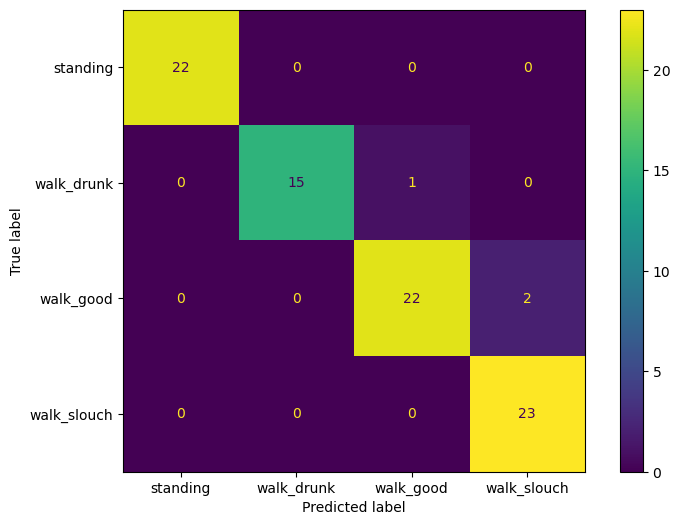

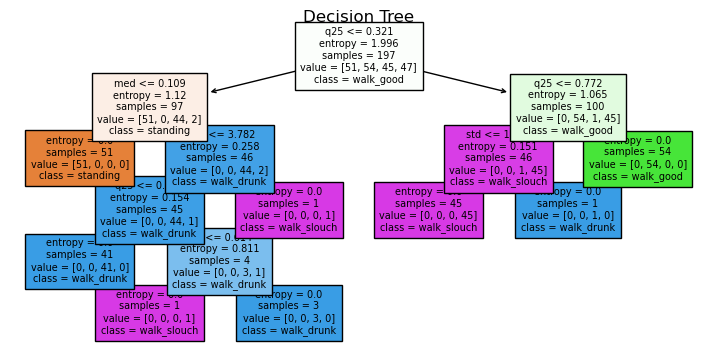

In [38]:
all_data_to_combined_csv()
%matplotlib inline
feature_frames = pd.read_csv('data/Activities/all_data.csv')
dt_model, dt_cm, accuracy = train_decision_tree(feature_frames)
with open('dt_model.pkl', 'wb') as f:
    pickle.dump(dt_model, f)

confusionMatrix = ConfusionMatrixDisplay(confusion_matrix=dt_cm, display_labels=dt_model.classes_)
confusionMatrix.plot()

viz_tree(dt_model, feature_frames, feature_frames['activity'].unique().tolist())

In [124]:
#test_live_classification()

# Live Demonstration

link: 